-> Gives 60% accuracy after tokenizing and training

In [1]:
!pip install -U spacy==3.*
!python -m spacy download en_core_web_sm

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.7/6.7 MB 30.3 MB/s eta 0:00:00
  Attempting uninstall: spacy
    Found existing installation: spacy 3.4.4
    Uninstalling spacy-3.4.4:
      Successfully uninstalled spacy-3.4.4
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
en-core-web-sm 3.4.1 requires spacy<3.5.0,>=3.4.0, but you have spacy 3.5.0 which is incompatible.
/usr/local/lib/python3.8/dist-packages/torch/cuda/__init__.py:497: UserWarning: Can't initialize NVML
  warnings.warn("Can't initialize NVML")
2023-02-27 04:11:56.210159: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enab

In [2]:
import matplotlib.pyplot as plt
import numpy as np
import spacy
import tensorflow as tf

from tensorflow import keras
from keras import layers
from sklearn.datasets import fetch_20newsgroups
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report
from sklearn.model_selection import train_test_split

/usr/local/lib/python3.8/dist-packages/torch/cuda/__init__.py:497: UserWarning: Can't initialize NVML
  warnings.warn("Can't initialize NVML")


In [3]:
# Download the *train* dataset without headers, footers, and quotes to make the problem more challenging.
train_corpus = fetch_20newsgroups(subset='train', remove=('headers', 'footers', 'quotes'))

In [4]:
# We don't need named entity recognition nor parsing. Removing them will speed up processing.
nlp = spacy.load('en_core_web_sm', disable=['ner', 'parser'])

In [6]:
def spacy_tokenizer(doc):
  return [t.lemma_.lower() for t in nlp(doc) if \
          len(t) > 2 and \
          not t.is_punct and \
          not t.is_space and \
          not t.is_stop and \
          t.is_alpha]

In [7]:
def preprocess_text(text):
  tokens = spacy_tokenizer(text)
  return "|".join(tokens)

In [8]:
%%time
preprocessed_train_corpus = [preprocess_text(post) for post in train_corpus.data]

CPU times: user 9min 18s, sys: 4.25 s, total: 9min 22s
Wall time: 9min 41s


In [9]:
print(preprocessed_train_corpus[0])
print(preprocessed_train_corpus[1])

wonder|enlighten|car|see|day|door|sport|car|look|late|early|call|bricklin|door|small|addition|bumper|separate|rest|body|know|tellme|model|engine|spec|year|production|car|history|info|funky|look|car|mail
fair|number|brave|soul|upgrade|clock|oscillator|share|experience|poll|send|brief|message|detail|experience|procedure|speed|attain|cpu|rate|speed|add|card|adapter|heat|sink|hour|usage|day|floppy|disk|functionality|floppy|especially|request|summarize|day|add|network|knowledge|base|clock|upgrade|answer|poll|thank


In [11]:
train_data, val_data, train_labels, val_labels = train_test_split(preprocessed_train_corpus, train_corpus.target, train_size=0.85, random_state=1)

In [12]:
print(len(train_data), len(val_data))

9616 1698


In [13]:
tokenizer = keras.preprocessing.text.Tokenizer(filters="", lower=False, split='|', oov_token='OOV')

In [14]:
tokenizer.fit_on_texts(train_data)

In [16]:
print(f"Vocabulary size: {len(tokenizer.word_index)}")

Vocabulary size: 45391


In [17]:
# Vectorize the first post using binary. We're using [:1] here because the 
# tokenizer expects an *array* of sequences.
print(train_data[:1])

# The resulting binary BoW has a 1 set for every word present in the sequence.
binary_bow = tokenizer.texts_to_matrix(train_data[:1])
print(f"Vector shape: {binary_bow.shape}")
print(binary_bow)

['sorry|followup|email|address|try|decide|printer|like|hear|user|printer|question|thank']
Vector shape: (1, 45392)
[[0. 0. 0. ... 0. 0. 0.]]


In [18]:
present_tokens = np.where(binary_bow[0] == 1)[0]
print(f"Token indices: {present_tokens}")
print(" ".join(tokenizer.index_word[n] for n in present_tokens))

Token indices: [   3   26   32   41   97  137  142  146  373  504  617 2595]
like try question thank hear address email user decide sorry printer followup


In [19]:
X_train = tf.sparse.from_dense(tokenizer.texts_to_matrix(train_data))

In [31]:
X_train.shape

TensorShape([9616, 45392])

In [21]:
print(train_labels)

[ 2  5  4 ... 15  6  2]


In [22]:
y_train = keras.utils.to_categorical(train_labels)

In [23]:
y_train.shape

(9616, 20)

In [24]:
X_val = tf.sparse.from_dense(tokenizer.texts_to_matrix(val_data))
y_val = keras.utils.to_categorical(val_labels)

In [25]:
NUM_CLASSES = len(train_corpus.target_names)
NUM_UNITS = 128

# "set_seed" is called to ensure we get the same weights every time. Comment out this
# line to get different weight initializations.
tf.random.set_seed(0)

# "kernel_initializer" is passed to ensure we get the same weights every time. Remove
# the parameter to get different weight initializations.
model = keras.Sequential([
  layers.Dense(NUM_UNITS, activation='relu', kernel_initializer=tf.keras.initializers.random_normal(seed=1)),
  layers.Dense(NUM_UNITS, activation='relu', kernel_initializer=tf.keras.initializers.random_normal(seed=1)),
  layers.Dense(NUM_CLASSES, activation='softmax', kernel_initializer=tf.keras.initializers.random_normal(seed=1))
])

In [26]:
model.compile(optimizer='rmsprop',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

In [32]:
NUM_EPOCHS = 4
BATCH_SIZE = 128

history = model.fit(X_train, y_train, epochs=NUM_EPOCHS, batch_size=BATCH_SIZE, validation_data=(X_val, y_val))

Epoch 1/4
76/76 [==============================] - 4s 51ms/step - loss: 0.1091 - accuracy: 0.9697 - val_loss: 1.9037 - val_accuracy: 0.6596
Epoch 2/4
76/76 [==============================] - 4s 57ms/step - loss: 0.1066 - accuracy: 0.9693 - val_loss: 1.9516 - val_accuracy: 0.6572
Epoch 3/4
76/76 [==============================] - 3s 38ms/step - loss: 0.1052 - accuracy: 0.9698 - val_loss: 1.9736 - val_accuracy: 0.6561
Epoch 4/4
76/76 [==============================] - 3s 36ms/step - loss: 0.1039 - accuracy: 0.9708 - val_loss: 1.9959 - val_accuracy: 0.6561


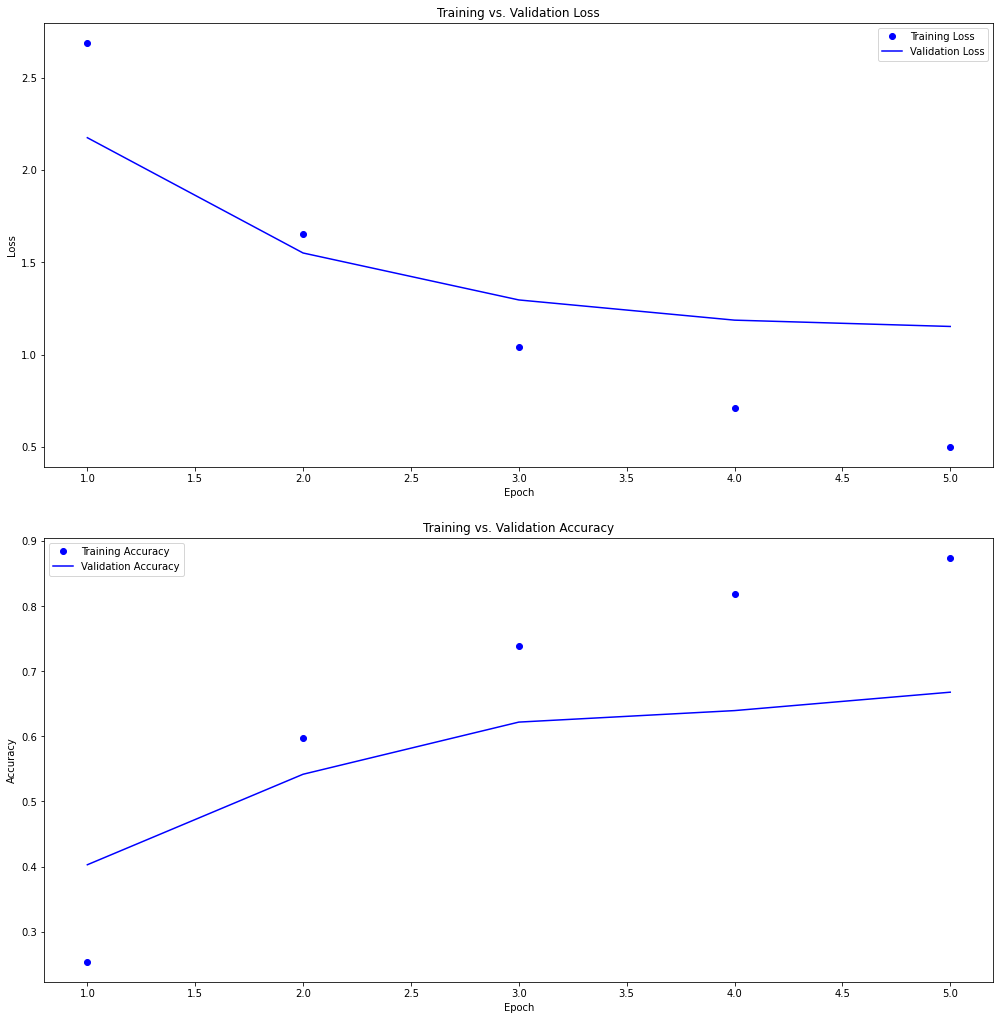

In [28]:
training_losses = history.history['loss']
validation_losses = history.history['val_loss']

training_accuracy = history.history['accuracy']
validation_accuracy = history.history['val_accuracy']

epochs = range(1, len(training_losses) + 1)

fig, (ax1, ax2) = plt.subplots(2)
fig.set_figheight(15)
fig.set_figwidth(15)
fig.tight_layout(pad=5.0)

# Plot training vs. validation loss.
ax1.plot(epochs, training_losses, 'bo', label='Training Loss')
ax1.plot(epochs, validation_losses, 'b', label='Validation Loss')
ax1.title.set_text('Training vs. Validation Loss')
ax1.set_xlabel('Epoch')
ax1.set_ylabel('Loss')
ax1.legend()

# PLot training vs. validation accuracy.
ax2.plot(epochs, training_accuracy, 'bo', label='Training Accuracy')
ax2.plot(epochs, validation_accuracy, 'b', label='Validation Accuracy')
ax2.title.set_text('Training vs. Validation Accuracy')
ax2.set_xlabel('Epoch')
ax2.set_ylabel('Accuracy')
ax2.legend()

plt.show()

##Testing the model


In [33]:
test_corpus = fetch_20newsgroups(subset='test', remove=('headers', 'footers', 'quotes'))

In [34]:
preprocessed_test_corpus = [preprocess_text(post) for post in test_corpus.data]

In [35]:
X_test = tf.sparse.from_dense(tokenizer.texts_to_matrix(preprocessed_test_corpus))
y_test = keras.utils.to_categorical(test_corpus.target)

In [36]:
results = model.evaluate(X_test, y_test)

236/236 [==============================] - 1s 3ms/step - loss: 2.8153 - accuracy: 0.5939


In [37]:
print(f"Test loss: {results[0]}")
print(f"Test accuracy: {results[1]}")

Test loss: 2.8152620792388916
Test accuracy: 0.5938661694526672
